<a href="https://colab.research.google.com/github/minhkhoiine/Tic-Tac-Toe-swift/blob/main/Image_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io, exposure, filters, morphology
from skimage.morphology import disk, binary_closing
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import os

In [2]:
def show_image(img, title=""):
    io.imshow(img)
    plt.title(title)
    io.show()

def show_histogram(img):
    hist = exposure.histogram(img)
    plt.bar(hist[1], hist[0])
    plt.title("Histogram")
    plt.show()

In [3]:
def extract_features(image_path, threshold=200, size_threshold=10, use_otsu=False, morph_close=False, show=False):
    try:
        img = io.imread(image_path)
        if show:
            show_image(img, "Original Image")

        if use_otsu:
            threshold = filters.threshold_otsu(img)
        img_binary = (img < threshold).astype(np.double)

        if morph_close:
            img_binary = binary_closing(img_binary, disk(1)).astype(np.double)

        if show:
            show_image(img_binary, f"Binary Image (th={threshold})")

        img_label = label(img_binary, background=0)
        if show:
            show_image(img_label, "Labeled Image")

        regions = regionprops(img_label)
        Features = []
        BBoxes = []

        fig, ax = plt.subplots()
        io.imshow(img_binary)

        for props in regions:
            minr, minc, maxr, maxc = props.bbox
            height, width = maxr - minr, maxc - minc
            if height < size_threshold or width < size_threshold:
                continue
            ax.add_patch(Rectangle((minc, minr), width, height, fill=False, edgecolor='red', linewidth=1))

            roi = img_binary[minr:maxr, minc:maxc]
            m = moments(roi)
            if m[0, 0] == 0:
                continue
            cc = m[0, 1] / m[0, 0]
            cr = m[1, 0] / m[0, 0]
            mu = moments_central(roi, center=(cr, cc))
            nu = moments_normalized(mu)
            hu = moments_hu(nu)
            Features.append(hu)
            BBoxes.append((minr, minc, maxr, maxc))

        ax.set_title('Bounding Boxes')
        if show:
            plt.show()

        return np.array(Features), BBoxes

    except Exception as e:
        print(f"[ERROR] Failed on image: {image_path}\n")
        return np.empty((0, 7)), []

In [4]:
def build_training_database(folder_path, label_map, threshold=200, use_otsu=False, morph_close=False):
    all_features = []
    all_labels = []
    for fname, label in label_map.items():
        path = os.path.join(folder_path, fname)
        feats, _ = extract_features(path, threshold=threshold, use_otsu=use_otsu, morph_close=morph_close)
        if feats is not None and len(feats) > 0:
            all_features.extend(feats)
            all_labels.extend([label] * len(feats))
    return np.array(all_features), np.array(all_labels)

In [5]:
def normalize_features(features):
    mean = features.mean(axis=0)
    std = features.std(axis=0)
    features_norm = (features - mean) / std
    return features_norm, mean, std

In [6]:
def recognize(features_db, labels_db, test_features):
    dist = cdist(test_features, features_db)
    nearest_indices = np.argsort(dist, axis=1)[:, :3]
    top_k_labels = labels_db[nearest_indices]

    predictions = []
    for row in top_k_labels:
        values, counts = np.unique(row, return_counts=True)
        majority = values[np.argmax(counts)]
        predictions.append(majority)

    return np.array(predictions)

def recognize_self(features_norm, labels):
    dist = cdist(features_norm, features_norm)
    np.fill_diagonal(dist, np.inf)
    nearest = np.argmin(dist, axis=1)
    predictions = labels[nearest]
    return predictions

In [7]:
def show_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    io.imshow(cm)
    plt.title("Confusion Matrix")
    plt.show()
    return cm

In [8]:
def match_groundtruth(bboxes, predictions, locations, gt_labels):
    matched_labels = []
    for i, (r, c, R, C) in enumerate(bboxes):
        center_found = False
        for j, (cy, cx) in enumerate(locations):
            if r <= cy <= R and c <= cx <= C:
                matched_labels.append((gt_labels[j], predictions[i]))
                center_found = True
                break
        if not center_found:
            matched_labels.append((-1, predictions[i]))

    label_reverse = {v: k[0] for k, v in label_map.items()}
    char_to_num = {v: k for k, v in label_reverse.items()}

    y_true = [char_to_num.get(str(t[0]), -999) for t in matched_labels if t[0] != -1]
    y_pred = [t[1] for t in matched_labels if t[0] != -1]
    correct = sum([a == b for a, b in zip(y_true, y_pred)])
    return correct / len(y_true), y_true, y_pred

In [9]:
def load_ground_truth(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)

    data = {k.decode() if isinstance(k, bytes) else k: v for k, v in data.items()}

    if 'locations' in data and 'classes' in data:
        return data['locations'], data['classes']
    else:
        raise KeyError(f"Ground truth file missing expected keys: {list(data.keys())}")

In [10]:
label_map = {
    'a.bmp': 1,
    'd.bmp': 2,
    'f.bmp': 3,
    'h.bmp': 4,
    'k.bmp': 5,
    'm.bmp': 6,
    'n.bmp': 7,
    'o.bmp': 8,
    'p.bmp': 9,
    'q.bmp': 10,
    'r.bmp': 11,
    's.bmp': 12,
    'u.bmp': 13,
    'w.bmp': 14,
    'x.bmp': 15,
    'z.bmp': 16
}

<ipython-input-3-7386a80abb99>:26: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img_binary)
<ipython-input-3-7386a80abb99>:26: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img_binary)
<ipython-input-3-7386a80abb99>:26: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img_binary)
<ipython-input-3-7386a80abb99>:26: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img_binary)
<ipython-input-3-7386a80abb99>:26: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `mat

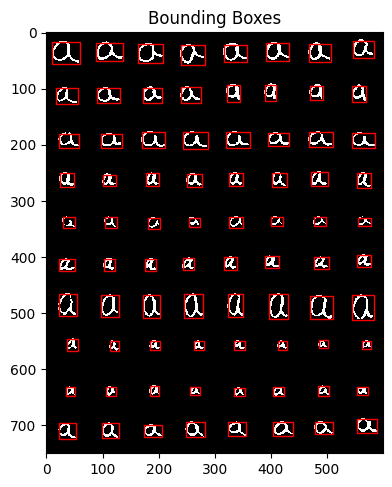

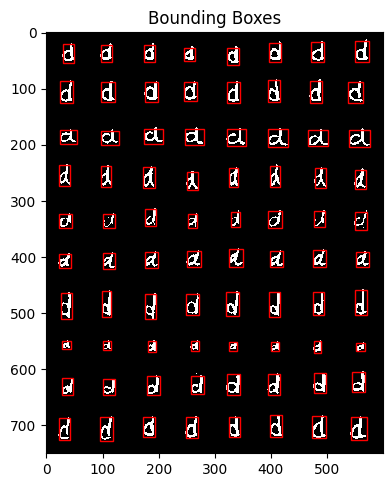

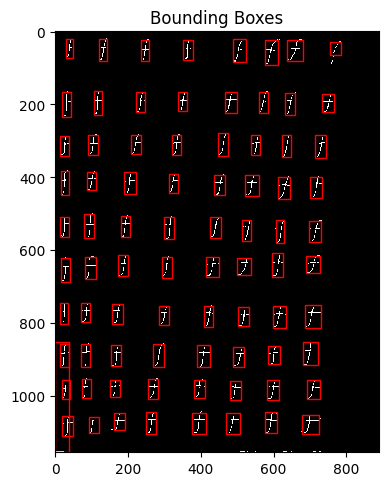

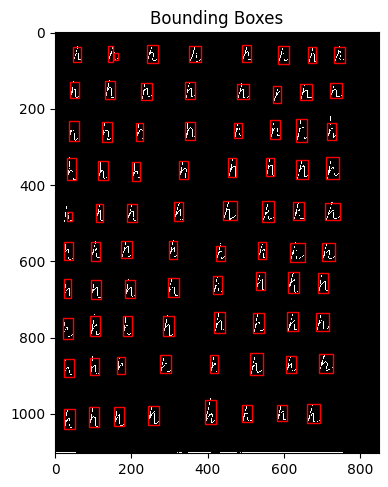

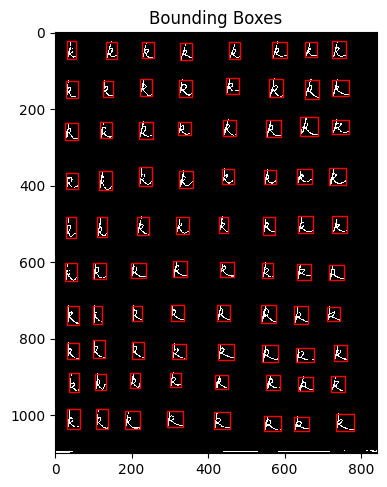

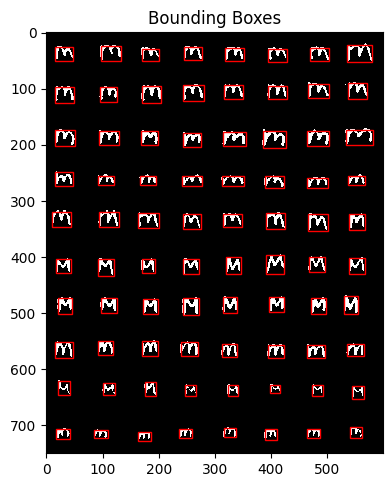

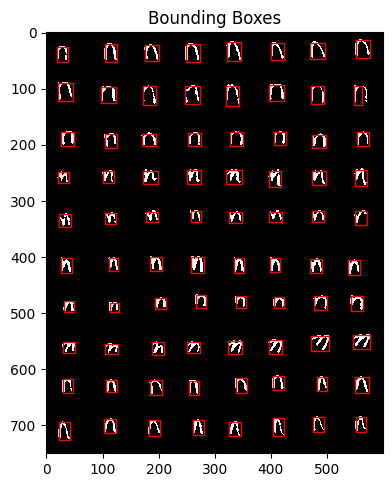

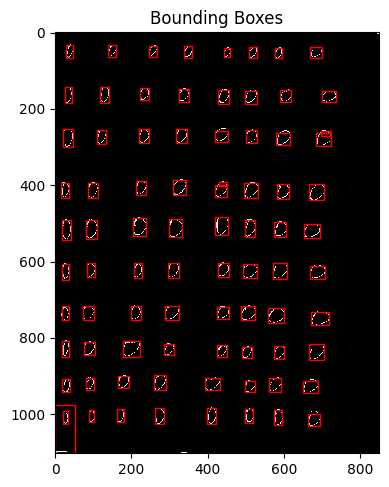

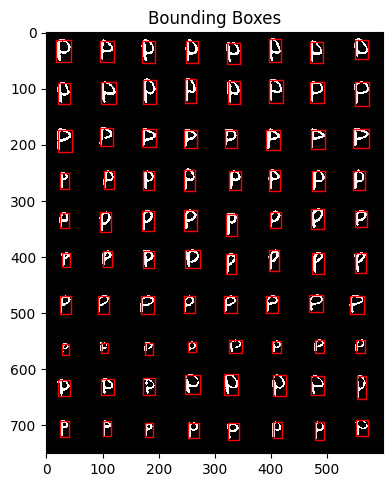

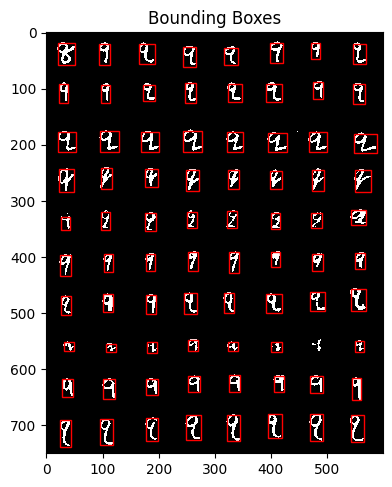

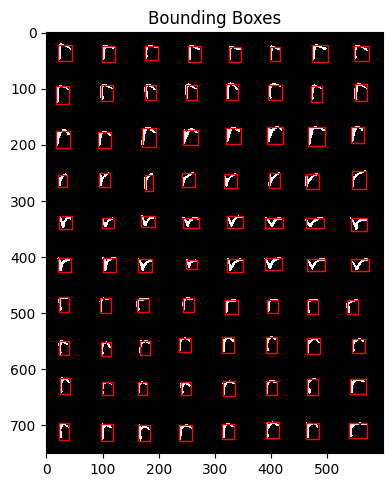

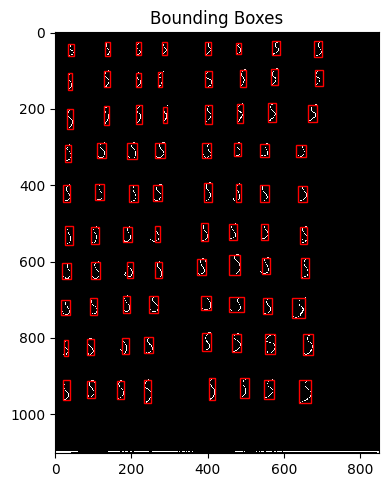

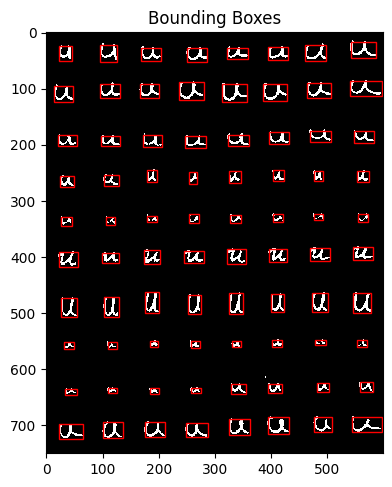

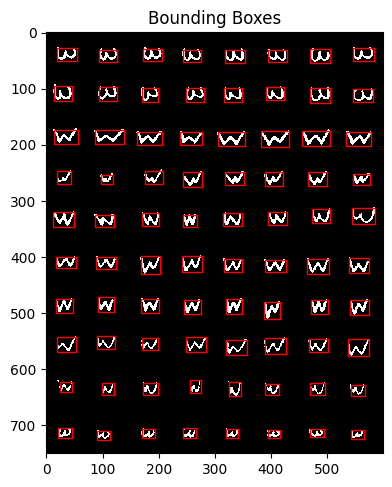

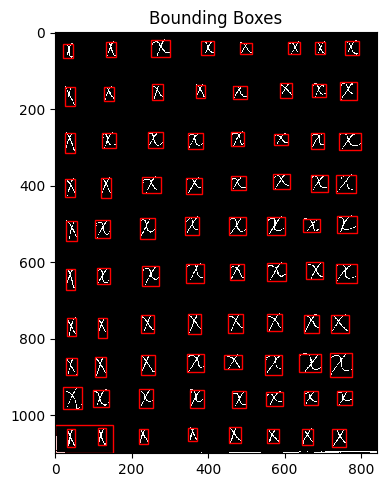

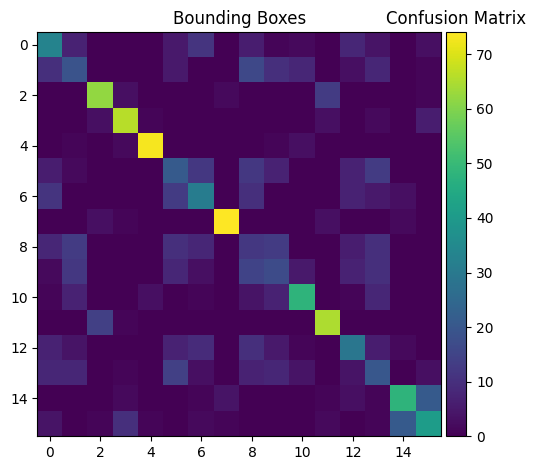

<ipython-input-3-7386a80abb99>:26: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img_binary)


Recognition Rate: 11.63%


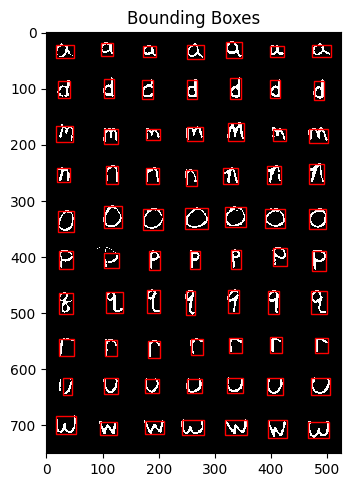

In [13]:
folder = "/content/drive/MyDrive/Colab Notebooks/Assignment4 image/H4-16images"
feats, labels = build_training_database(folder, label_map, use_otsu=True, morph_close=True)
feats_norm, mean, std = normalize_features(feats)
preds_train = recognize_self(feats_norm, labels)
show_confusion(labels, preds_train)

test_feats, bboxes = extract_features(os.path.join(folder, 'test1.bmp'), use_otsu=True, morph_close=True)
test_feats_norm = (test_feats - mean) / std
test_preds = recognize(feats_norm, labels, test_feats_norm)
locs, gt_labels = load_ground_truth(os.path.join(folder, 'test_gt_py3.pkl'))
rate, y_true, y_pred = match_groundtruth(bboxes, test_preds, locs, gt_labels)
print(f"Recognition Rate: {rate*100:.2f}%")



In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def build_training_database_enhanced(folder_path, label_map, threshold=200, use_otsu=False, morph_close=False):
    all_features = []
    all_labels = []
    for fname, label in label_map.items():
        path = os.path.join(folder_path, fname)
        feats, _ = extract_features_with_enhancements(path, threshold=threshold, use_otsu=use_otsu, morph_close=morph_close)
        if feats is not None and len(feats) > 0:
            all_features.extend(feats)
            all_labels.extend([label] * len(feats))
    return np.array(all_features), np.array(all_labels)


In [ ]:
def extract_features_with_enhancements(image_path, threshold=200, size_threshold=10, use_otsu=False, morph_close=False, show=False):
    try:
        img = io.imread(image_path)
        if img.ndim == 3:
            img = img[..., 0]

        if use_otsu:
            threshold = filters.threshold_otsu(img)
        img_binary = (img < threshold).astype(np.double)

        if morph_close:
            img_binary = binary_closing(img_binary, disk(1)).astype(np.double)

        img_label = label(img_binary, background=0)
        regions = regionprops(img_label)

        Features = []
        BBoxes = []

        for props in regions:
            minr, minc, maxr, maxc = props.bbox
            if (maxr - minr) < size_threshold or (maxc - minc) < size_threshold:
                continue

            roi = img_binary[minr:maxr, minc:maxc]
            m = moments(roi)
            if m[0, 0] == 0:
                continue
            cc = m[0, 1] / m[0, 0]
            cr = m[1, 0] / m[0, 0]
            mu = moments_central(roi, center=(cr, cc))
            nu = moments_normalized(mu)
            hu = moments_hu(nu)

            eccentricity = props.eccentricity
            extent = props.extent
            solidity = props.solidity
            aspect_ratio = (maxc - minc) / (maxr - minr + 1e-6)

            feature_vec = np.concatenate([hu, [eccentricity, extent, solidity, aspect_ratio]])
            Features.append(feature_vec)
            BBoxes.append((minr, minc, maxr, maxc))

        return np.array(Features), BBoxes

    except Exception as e:
        print("Error")
        return np.empty((0, 11)), []

Feature shape: (1289, 11)


<ipython-input-136-410c288367d2>:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(cm)
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


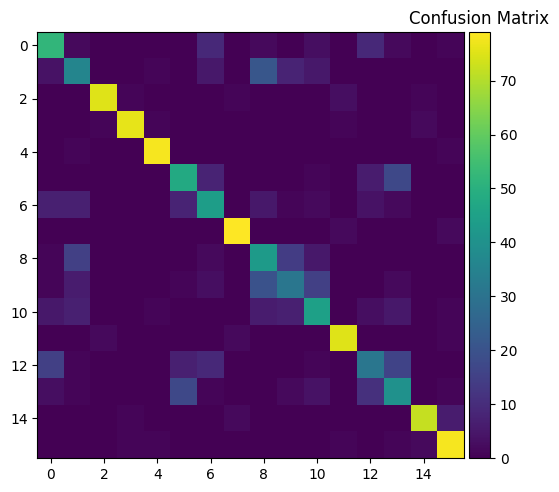

Recognition Rate: 13.95%


In [ ]:
folder = "/content/drive/MyDrive/Colab Notebooks/Assignment4 image/H4-16images"
feats, labels = build_training_database_enhanced(folder, label_map, use_otsu=True, morph_close=True)
feats = np.array(feats)
labels = np.array(labels)
print("Feature shape:", feats.shape)

if feats.ndim != 2 or feats.shape[0] == 0:
    print("Error")
else:
    feats_norm, mean, std = normalize_features(feats)
    preds_train = recognize_self(feats_norm, labels)
    show_confusion(labels, preds_train)

    test_feats, bboxes = extract_features_with_enhancements(os.path.join(folder, 'test1.bmp'), use_otsu=True, morph_close=True)
    test_feats_norm = (test_feats - mean) / std
    test_preds = recognize(feats_norm, labels, test_feats_norm)
    locs, gt_labels = load_ground_truth(os.path.join(folder, 'test_gt_py3.pkl'))
    rate, y_true, y_pred = match_groundtruth(bboxes, test_preds, locs, gt_labels)
    print(f"Recognition Rate: {rate*100:.2f}%")